In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema


In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Work\Projects\\python\\flask\strategies\\igdata'

In [4]:
pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['naturalgas_1H', 'naturalgas_4H', 'naturalgas_D']


In [5]:

df = {}
dd = {}

for pair in range(len(pairs_list)):
    t = str(pairs_list[pair].split('_')[1])
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 2)
    #df[pair].drop([4,5,6,7,8,9,10,11,12], axis=01)
    #df[pair] = df[pair].iloc[0,1,2,3,4,13]
    df[pair] = df[pair].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
    df[pair].columns = ['Date', 'Bid Open', 'Bid High', 'Bid Low', 'Bid Close',\
                                'Ask Open', 'Ask High', 'Ask Low', 'Ask Close',\
                                'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Open'] = df[pair]['Bid Open']
    df[pair]['High'] = df[pair]['Bid High']
    df[pair]['Low'] = df[pair]['Bid Low']
    df[pair]['Close'] = df[pair]['Bid Close']
    #df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    #df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y.%m.%d %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''
    dd[t] = df[pair]
    
for key in dd:
    print(f'Key: {key} - rows: {len(dd[key])}')


Key: 1H - rows: 5914
Key: 4H - rows: 1598
Key: D - rows: 939


In [6]:
def SMA(df, period):
    df[str(period) + '_sma'] = df['Close'].rolling(period).mean()
    print(str(period) + '_sma')
    print(df.head(200))
    return df[str(period) + '_sma']

def EMA(df, period):
    df[str(period) + '_ema'] = df['Close'].ewm(span = period,adjust=False).mean()
    print(df.head(20))
    return  df[str(period) + '_ema']

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5

plot_trades = False

200_sma
                     Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
Date                                                                    
2022-02-18 00:00:00    4497.0    4499.0   4453.0     4457.0    4500.0   
2022-02-18 01:00:00    4460.0    4465.0   4417.0     4419.0    4463.0   
2022-02-18 02:00:00    4418.0    4437.0   4410.0     4432.0    4421.0   
2022-02-18 03:00:00    4433.0    4434.0   4423.0     4425.0    4436.0   
2022-02-18 04:00:00    4426.0    4428.0   4379.0     4380.0    4429.0   
...                       ...       ...      ...        ...       ...   
2022-03-02 13:00:00    4735.0    4816.0   4710.0     4816.0    4738.0   
2022-03-02 14:00:00    4811.0    4825.0   4705.0     4730.0    4814.0   
2022-03-02 15:00:00    4731.0    4743.0   4680.0     4702.0    4734.0   
2022-03-02 16:00:00    4701.0    4759.0   4654.0     4749.0    4704.0   
2022-03-02 17:00:00    4751.0    4783.0   4726.0     4743.0    4754.0   

                     Ask High  Ask Low  As

                     Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
Date                                                                    
2022-02-18 00:00:00    4497.0    4499.0   4453.0     4457.0    4500.0   
2022-02-18 01:00:00    4460.0    4465.0   4417.0     4419.0    4463.0   
2022-02-18 02:00:00    4418.0    4437.0   4410.0     4432.0    4421.0   
2022-02-18 03:00:00    4433.0    4434.0   4423.0     4425.0    4436.0   
2022-02-18 04:00:00    4426.0    4428.0   4379.0     4380.0    4429.0   
2022-02-18 05:00:00    4383.0    4388.0   4319.0     4335.0    4386.0   
2022-02-18 06:00:00    4336.0    4417.0   4331.0     4382.0    4339.0   
2022-02-18 07:00:00    4383.0    4416.0   4343.0     4411.0    4386.0   
2022-02-18 08:00:00    4412.0    4431.0   4380.0     4383.0    4415.0   
2022-02-18 09:00:00    4382.0    4391.0   4361.0     4384.0    4385.0   
2022-02-18 10:00:00    4383.0    4414.0   4364.0     4401.0    4386.0   
2022-02-18 11:00:00    4402.0    4419.0   4375.0   

200_sma
                     Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
Date                                                                    
2020-02-10 05:00:00    1818.0    1819.0   1774.0     1787.0    1821.0   
2020-02-11 05:00:00    1786.0    1814.0   1769.0     1806.0    1789.0   
2020-02-12 05:00:00    1805.0    1869.0   1805.0     1856.0    1808.0   
2020-02-13 05:00:00    1855.0    1881.0   1832.0     1838.0    1858.0   
2020-02-14 05:00:00    1837.0    1864.0   1815.0     1855.0    1840.0   
...                       ...       ...      ...        ...       ...   
2020-09-25 05:00:00    2798.0    2861.0   2745.0     2757.0    2801.0   
2020-09-27 05:00:00    2780.0    2823.0   2772.0     2801.0    2785.0   
2020-09-28 05:00:00    2800.0    2821.0   2713.0     2781.0    2803.0   
2020-09-29 05:00:00    2782.0    2800.0   2514.0     2528.0    2785.0   
2020-09-30 05:00:00    2529.0    2629.0   2479.0     2623.0    2532.0   

                     Ask High  Ask Low  As

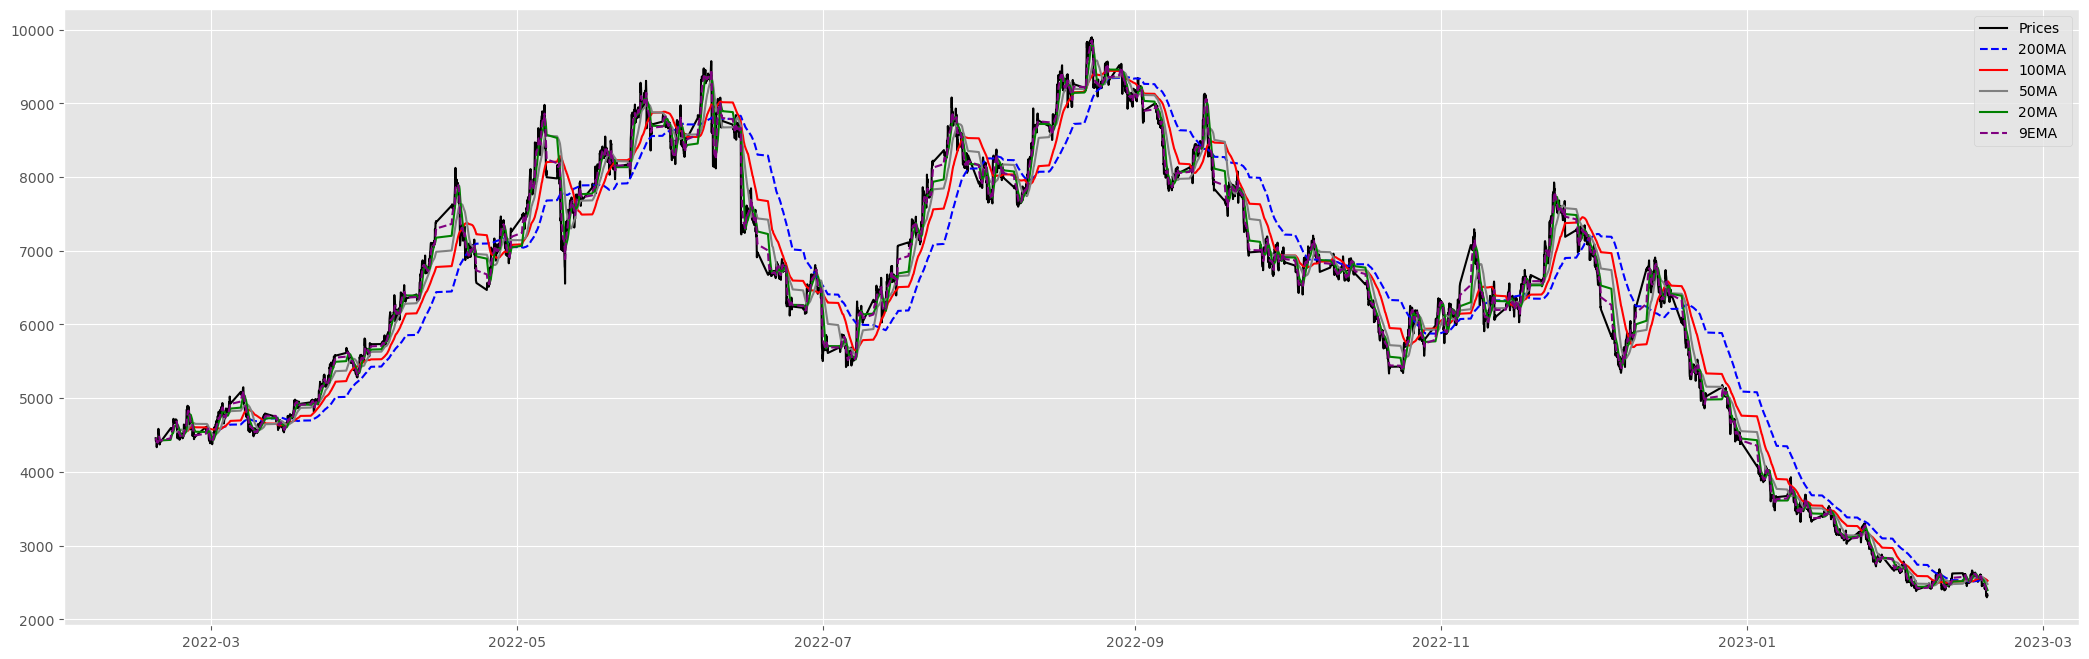

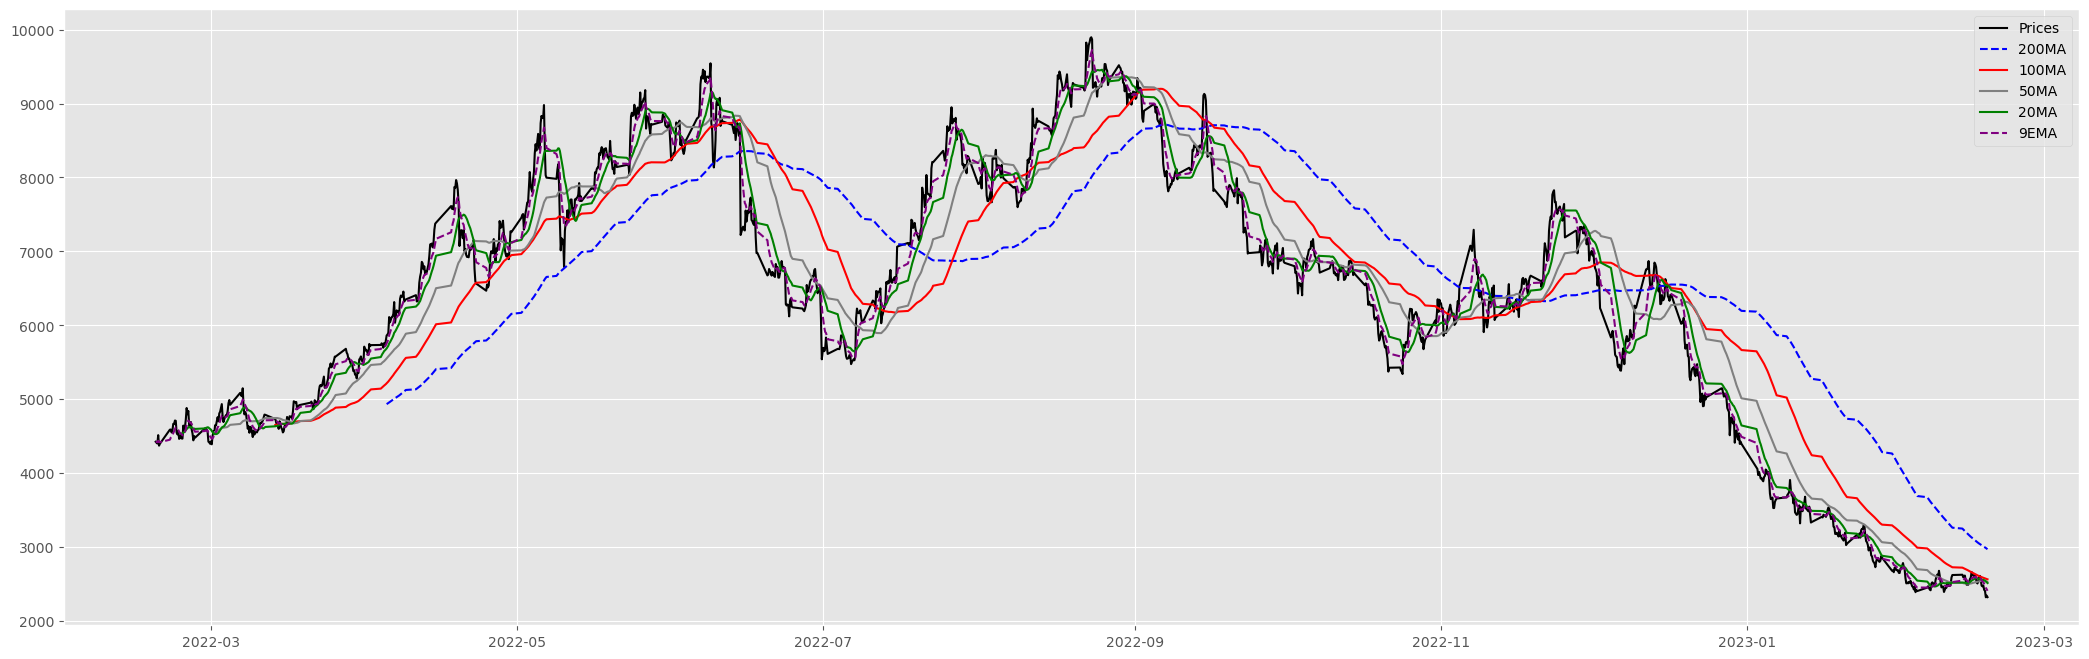

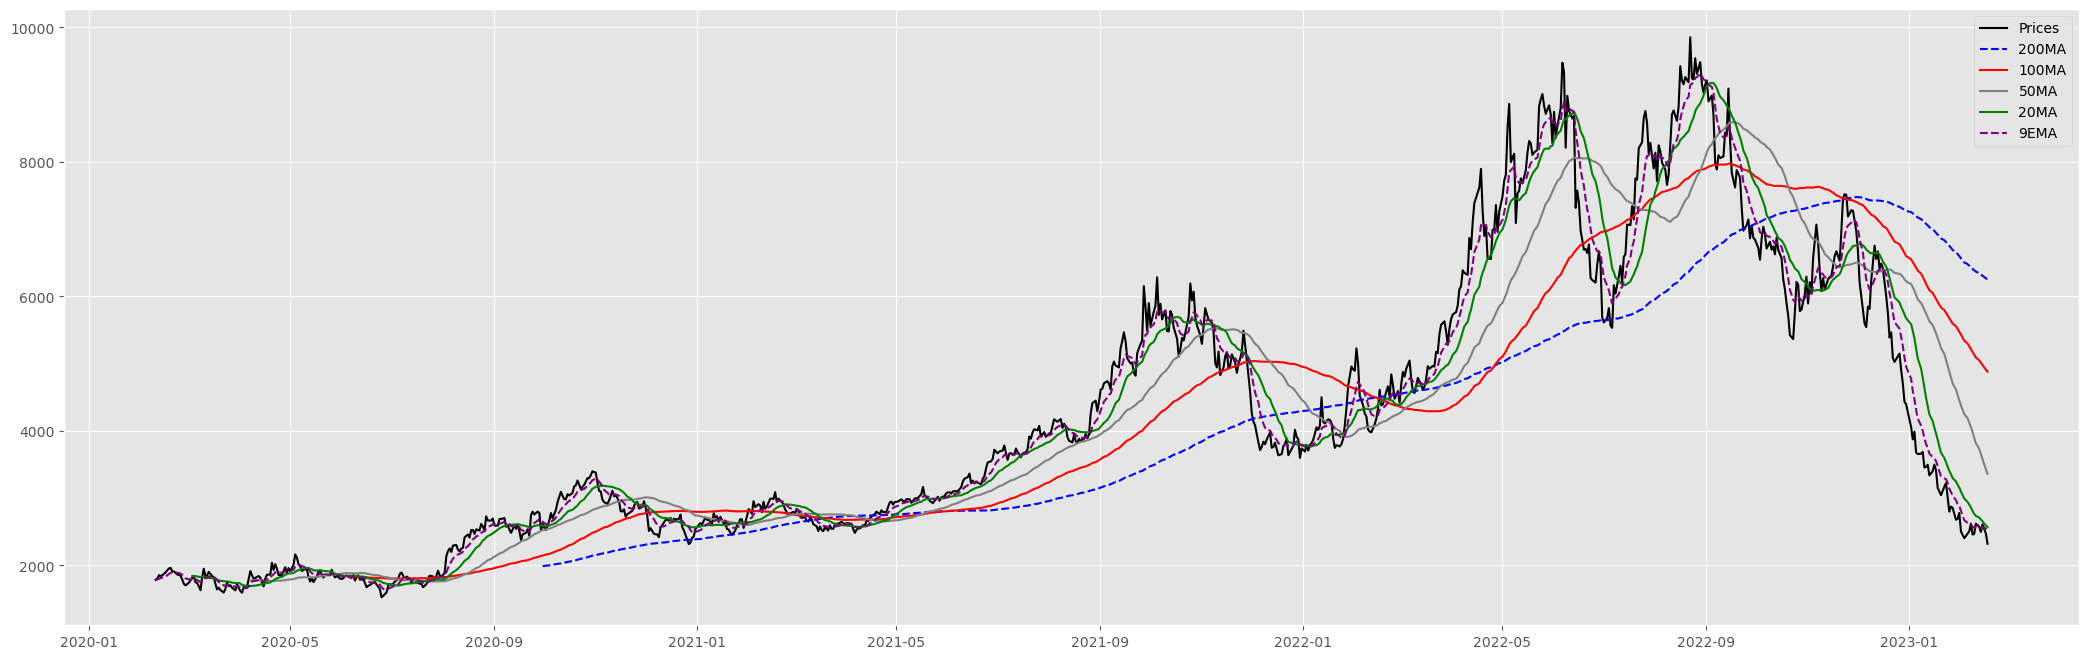

In [8]:
for pair in range(len(pairs_list)):
    price = df[pair]['Close']
    #SMA(df[pair], 200).to_csv('200sma.csv')
    df[pair]['200_sma'] = SMA(df[pair], 200)
    df[pair]['100_sma'] = SMA(df[pair], 100)
    df[pair]['50_sma'] = SMA(df[pair], 50)
    df[pair]['20_sma'] = SMA(df[pair], 20)
    df[pair].to_csv('sma.csv')
    df[pair]['9_ema'] = EMA(df[pair], 9)
    plt.figure(figsize = (26, 8))
    #plt.plot({'Open':df[pair]['Open'],'Close':df[pair]['Close'],'High':df[pair]['High'],'Low':df[pair]['Low']})
    #quotes = [df[pair]['Open'], df[pair]['Close'], df[pair]['High'], df[pair]['Low'], df[pair]['Close']]
    #ax = plt.gca()
    #h = matplotlib.finance.candlestick(ax, quotes)
    #plt.show()
    plt.plot(df[pair]['Close'], label='Prices',color = 'black')
    plt.plot(df[pair]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    plt.plot(df[pair]['100_sma'], label='100MA',color = 'red')
    plt.plot(df[pair]['50_sma'], label='50MA',color = 'grey')
    plt.plot(df[pair]['20_sma'], label='20MA',color = 'green')
    plt.plot(df[pair]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')
    plt.legend()
    #plt.figure()

    

In [9]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

In [11]:

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    support[pair] = []
    resist[pair] = []

    for i in range(50, len(df[pair])):
        # Determine the trend on 4HR
        
        if (df[pair]['max'][i - 12] != '') and df[pair]['max'][i - 12] > 0:
            resist[pair].append(df[pair]['max'][i - 12])
        elif (df[pair]['max'][i - 12] != '') and df[pair]['min'][i - 12] > 0:
            support[pair].append(df[pair]['min'][i - 12])
        #Buy
        if support[pair] != [] and any(df[pair]['Close'][i - 1] > s for s in support[pair]) and any(df[pair]['Close'][i] <= s for s in support[pair])             and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            support[pair].remove(support[pair][-1])

        #Sell
        if resist[pair] != [] and any(df[pair]['Close'][i - 1] < r for r in resist[pair]) and any(df[pair]['Close'][i] >= r for r in resist[pair])             and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            resist[pair].remove(resist[pair][-1])

        #Exit trades---------------------------------------------------------------------------
        #Buy Trailing SL
        if any(y <= df[pair]['Close'][i] for y in long_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    #Move SL to BE
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + df[pair]['spread'][i]})
                        print(j,
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_entry_price[pair] = []
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL)})
                        print(j,
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to second ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 3 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j,
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
        #Sell Trailing SL
        if any(y >= df[pair]['Close'][i] for y in short_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    #Move SL to BE
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - df[pair]['spread'][i]})
                        print(j,
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_entry_price[pair] = []
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL)})
                        print(j,
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 3 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j,
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])

        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])

        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if (i - trade[pair][j]['ID']) >= 12:
                        trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        #plot trade
                        if plot_trades == True:
                            trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
                    elif (i - trade[pair][j]['ID']) >= 12:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                        #plot trade
                        if plot_trades == True:
                            trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])


In [12]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [13]:
for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []

    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    #pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


KeyError: "None of ['date_of_trade'] are in the columns"

In [ ]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [ ]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
#print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
#print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
#print('Max profitable trade:', round(max(str_profits), 2))
#print('Max lossing trade:', round(min(str_losses), 2))

In [ ]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


In [ ]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    #print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    #print('Number of profits:', len(profits[pair]))
    #print('Number of losses:', len(losses[pair]))
    #print('Number of breakevens:', len(be[pair]), '\n')
    #print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    #print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    #print('--------------------------------')
    #print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    #print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    #print('Max profitable trade:', round(max(profits[pair]), 2))
    #print('Max lossing trade:', round(min(losses[pair]), 2))
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()
